데이터 전처리 

아파트 매매가 전세가 지수

In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import pandas as pd
import xlwings as xw
%matplotlib inline

def KBpriceindex_preprocessing(path, data_type):
    wb = xw.Book(path)
    sheet = wb.sheets[data_type]
    row_num = sheet.range(1,1).end('down').end('down').end('down').row
    data_range = 'A2:GE' + str(row_num)
    raw_data = sheet[data_range].options(pd.DataFrame, index=False, header=True).value
    bignames = "서울 대구 부산 대전 광주 인천 울산 세종 경기 강원 충북 충남 전북 전남 경부 경남 제주도 6개광역시 5개광역시 수도권 기타지역 구분 전국"
    bigname_list = bignames.split(" ")
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])

    for num, gu_data in enumerate(small_col):
        if gu_data == None:
            small_col[num] = big_col[num]
        check = num
        
        while True:
            if big_col[check] in bigname_list:
                big_col[num] = big_col[check]
                break
            else:
                check = check - 1
                
    big_col[129] = '경기'
    big_col[130] = '경기'
    small_col[185] = '서귀포'
    
    raw_data.columns = [big_col, small_col]
    new_col_data = raw_data.drop([0,1])

    index_list = list(new_col_data['구분']['구분'])

    new_index = []

    for num , raw_index in enumerate(index_list):
        temp = str(raw_index).split('.')

        if int(temp[0]) > 12:
            if len(temp[0]) == 2:
                new_index.append('19'+temp[0]+'.'+temp[1])
            else:
                new_index.append(temp[0]+'.'+temp[1])

        else:
            new_index.append(new_index[num-1].split('.')[0] + '.' + temp[0])      

    new_col_data.set_index(pd.to_datetime(new_index), inplace=True)
    cleaned_data = new_col_data.drop(('구분','구분'), axis=1)
    return cleaned_data

아파트 매매가격 지수와 전세가격 지수 가져오기

In [2]:
# KBpriceindex_preprocessing 함수 사용

path = r'데이터/★(월간)KB주택가격동향_시계열(2020.08).xlsx'
#매매가 전세가
price_index = KBpriceindex_preprocessing(path, '매매apt')
jeonse_index = KBpriceindex_preprocessing(path, '전세apt')

In [3]:
#한글 폰트
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

datatime = (년, 월, 일) 사용 // dateutil은 날짜 관련 여러 가지 연산을 위한 모듈//

특정 날짜를 기준으로 몇달전, 몇달후 같은 상대날짜를 계산하는데 사용

In [4]:
#매매가 지수 데이터 프레임에서 특정 날짜 기준으로 데이터 가져오기
from datetime import datetime
from dateutil.relativedelta import relativedelta

index_data = datetime(2020,1,1)
time_range = 12
prev_date = index_data - relativedelta(months=time_range)

print(index_data)
print(prev_date)

#loc 행 전체 // iloc 열 전체
price_index.loc[index_data]

2020-01-01 00:00:00
2019-01-01 00:00:00


전국   전국      100.103
서울   서울      103.606
     강북      102.734
     강북구     101.271
     광진구     105.129
              ...   
경남   김해      93.9843
     통영      98.8472
제주도  제주도        None
     서귀포     97.7055
     기타지방    96.7348
Name: 2020-01-01 00:00:00, Length: 186, dtype: object

In [5]:
price_index.loc['2020-1-1']

전국   전국      100.103
서울   서울      103.606
     강북      102.734
     강북구     101.271
     광진구     105.129
              ...   
경남   김해      93.9843
     통영      98.8472
제주도  제주도        None
     서귀포     97.7055
     기타지방    96.7348
Name: 2020-01-01 00:00:00, Length: 186, dtype: object

특정 날짜 기준으로 모든 지역의 가격지수 증감률을 계산
<br> 1년전의 매매가격 지수를 가져오려면 price_index[prev_date] 

증감률 = (현재 날짜 지수 값 - 이전 날짜 지수 값) / 이전 날짜 지수 값

In [6]:
#1년동안의 매매가 지수 증감 구하기

(price_index.loc[index_data] - price_index.loc[prev_date])/price_index.loc[prev_date]

전국   전국      0.00102727
서울   서울       0.0360552
     강북       0.0273394
     강북구      0.0127081
     광진구      0.0512948
                ...    
경남   김해      -0.0601569
     통영       -0.011528
제주도  제주도            NaN
     서귀포      -0.022945
     기타지방    -0.0326525
Length: 186, dtype: object

계산한 가격지수 증감률 데이터 >>> 데이터 프레임 형태로 저장

In [7]:
demand_df = pd.DataFrame()
demand_df['매매증감률'] = (price_index.loc[index_data] - price_index.loc[prev_date])/price_index.loc[prev_date]
demand_df['전세증감률'] = (jeonse_index.loc[index_data] - jeonse_index.loc[prev_date]) / jeonse_index.loc[prev_date]

In [8]:
#4% 절대치 감소한 값 구하기
demand_df['매매증감률*0.96'] = (price_index.loc[index_data] - price_index.loc[prev_date])/price_index.loc[prev_date]*0.96
demand_df['전세증감률*0.96'] = (jeonse_index.loc[index_data] - jeonse_index.loc[prev_date]) / jeonse_index.loc[prev_date]*0.96

기준 날짜의 매매가 지수와 지난 3년 동안 최댓값 비교

주의할 점은 기준 날짜인 2020년 1월 데이터는 배야 하므로 마지막에서 하나 전까지만 데이터를 가져오라는 [:-1] 

코드 추가

In [9]:
#기준 날짜 ~ 지난 3년간 데이터 가져오기

prev_date2 = index_data - relativedelta(months=time_range*3)
price_index[prev_date2:index_data][:-1]

전국       서울                                               \
                 전국       서울       강북      강북구      광진구      노원구      도봉구   
2017-01-01  95.8625  83.6799  84.7621   87.062  83.0318   85.184  84.3273   
2017-02-01  95.8663   83.712  84.8192  87.1227  82.9924  85.3111  84.3815   
2017-03-01  95.8833  83.7957  84.8876  87.1542   83.007  85.4563  84.4216   
2017-04-01  95.9159   83.911   84.988  87.2256  83.0513  85.5837  84.5425   
2017-05-01  95.9624  84.0954  85.1157  87.3018  83.2426  85.7195  84.6513   
2017-06-01  96.1766  84.8129  85.7676  87.6023  84.4789  86.6308  85.1853   
2017-07-01   96.427  85.5413  86.5229  87.8696   84.983   87.928  86.1326   
2017-08-01  96.7024    86.44   87.389  88.6433  86.0924  89.0067  87.3505   
2017-09-01  96.7567  86.5691  87.5596  88.9465  86.5273  88.9425  87.4265   
2017-10-01  96.8537  86.9553  87.9047  89.1701  87.2415  89.1132  87.7004   
2017-11-01    96.98  87.4942  88.3703  89.5528  88.4544  89.3219  88.0527   
2017-12-01  97.0968  88.0725   88.777  89.7843  89.3358  89.4983  88.4095   
2018-01-01  97.2988  89.0618   89.381  89.9225  90.7394  89.6321  88.8207   
2018-02-01  97.4972  89.9397   89.997  90.2517  92.1078  90.0334  89.0844   
2018-03-01  97.7636  91.0677  91.0304  90.6799  93.8976   90.724   89.578   
2018-04-01  97.8966  91.8071  91.6836  91.0572  94.5549  91.1696  90.1543   
2018-05-01   97.948  92.1726  92.0463  91.2819  94.7166  91.3508  90.9359   
2018-06-01  98.0026  92.5314  92.3843  91.7417  94.7193  91.4554  91.1742   
2018-07-01  98.0223  93.0204  92.9039  91.9075  95.0213  91.8042  91.5131   
2018-08-01  98.2492  94.1066  93.8299  92.3238  95.3939  92.7366  92.5774   
2018-09-01  99.3156  97.7155  97.3781  97.4254   98.136  96.9043   96.709   
2018-10-01  99.9258   99.512  99.3301  99.4855  99.6651  99.2299  98.9141   
2018-11-01   100.03  99.9051  99.8288  99.9023  99.9635  99.8544  99.6861   
2018-12-01  100.028  100.014  99.9964  99.9389      100  100.022    99.94   
2019-01-01      100      100      100      100      100      100      100   
2019-02-01  99.8856  99.9081  99.9683  100.016  99.9975  99.9625  99.9983   
2019-03-01  99.6933  99.7392  99.8989  99.9564  99.9421  99.9151  99.9862   
2019-04-01  99.4526  99.5953  99.8455  99.9312  99.8002  99.8461  99.9549   
2019-05-01  99.3148  99.5347   99.797  99.9115  99.7434  99.8361  99.9499   
2019-06-01  99.1176  99.4589  99.7112  99.8936  99.6576  99.7242  99.8876   
2019-07-01  99.0299  99.8266  100.021   100.04  100.121  100.133  100.208   
2019-08-01  99.0144  100.229  100.389  100.208  100.629  100.532   100.45   
2019-09-01  99.0415  100.677  100.799  100.419  101.198  100.795   100.72   
2019-10-01  99.1522   101.26  101.155  100.528  102.074  100.917  100.771   
2019-11-01   99.297   101.83  101.558  100.658  103.108  101.135  100.935   
2019-12-01  99.7259   102.92  102.204  100.955   104.44   101.51  101.201   

                                       ...       경남                    \
               동대문구      마포구     서대문구  ...      의창구      진해구       양산   
2017-01-01  84.2679  81.8458  85.2171  ...  112.747  111.085  102.364   
2017-02-01  84.3522  81.9313   85.275  ...  112.524  110.744  102.386   
2017-03-01  84.4079  81.9608  85.3795  ...  112.352  110.614  102.424   
2017-04-01   84.438  82.1235  85.4797  ...  112.266   110.45  102.278   
2017-05-01  84.5862  82.3144  85.5682  ...  112.032  109.931  102.233   
2017-06-01  84.9394  83.0512  85.7785  ...  111.624  109.805  102.147   
2017-07-01  85.5199  83.8164  86.2986  ...  111.053   109.64  101.968   
2017-08-01  86.3552  84.9226  86.9197  ...  110.645  109.209  101.906   
2017-09-01  86.6489  85.2931  87.1118  ...  110.159  108.199  101.774   
2017-10-01  86.9662  85.6803  87.5688  ...  109.487  108.075  101.702   
2017-11-01     87.3  86.4441  88.2315  ...  108.316  107.513   101.44   
2017-12-01  87.5834  87.2258  88.7503  ...  107.644  107.186  101.289   
2018-01-01  88.2308  88.3635  88.9961  ...  107.319  106.711  101.15

위 데이터프레임에서 지역별로 최대값을 찾는다.

max()함수를 사용 // 칼럼의 최대값 구한 후, 컬럼명이 인덱스이고, 최대값이 데이터 값인 시리즈를 반환한다.

In [10]:
price_index[prev_date2:index_data][:-1].max()

전국   전국      100.029606
서울   서울      102.919808
     강북      102.203567
     강북구     100.954568
     광진구     104.440280
                ...    
경남   김해      111.729884
     통영      109.490780
제주도  제주도            NaN
     서귀포     101.454004
     기타지방    104.831444
Length: 186, dtype: float64

In [11]:
#demand_df 에 지난 최대값과 기준날짜 값의 최대값 대비 증감률 저장

demand_df['이전최대값'] = price_index[prev_date2:index_data][:-1].max()
demand_df['최댓값대비증감률'] = (price_index.loc[index_data] - demand_df['이전최대값'])/demand_df['이전최대값']

In [12]:
#0.96 값
demand_df['이전최대값*0.96'] = price_index[prev_date2:index_data][:-1].max()*0.96
demand_df['최댓값대비증감률*0.96'] = (price_index.loc[index_data] - demand_df['이전최대값*0.96'])/demand_df['이전최대값*0.96']

In [13]:
demand_df['최댓값대비증감률*0.96'] > 0

demand_df['최댓값대비상승*0.96'] = demand_df['최댓값대비증감률*0.96'] > 0

In [14]:
demand_df

매매증감률        전세증감률   매매증감률*0.96   전세증감률*0.96       이전최대값  \
전국  전국    0.00102727  -0.00648086  0.000986178  -0.00622163  100.029606   
서울  서울     0.0360552   0.00496245     0.034613   0.00476395  102.919808   
    강북     0.0273394  0.000353055    0.0262459  0.000338933  102.203567   
    강북구    0.0127081  -0.00524842    0.0121998  -0.00503848  100.954568   
    광진구    0.0512948    0.0159401    0.0492431    0.0153025  104.440280   
...              ...          ...          ...          ...         ...   
경남  김해    -0.0601569   -0.0735392   -0.0577506   -0.0705977  111.729884   
    통영     -0.011528  -0.00123509   -0.0110669  -0.00118568  109.490780   
제주도 제주도          NaN          NaN          NaN          NaN         NaN   
    서귀포    -0.022945  -0.00433929   -0.0220272  -0.00416571  101.454004   
    기타지방  -0.0326525   -0.0220008   -0.0313464   -0.0211208  104.831444   

            최댓값대비증감률  이전최대값*0.96 최댓값대비증감률*0.96  최댓값대비상승*0.96  
전국  전국    0.00073099   96.028422     0.0424281          True  
서울  서울    0.00666256   98.803015     0.0486068          True  
    강북    0.00518942   98.115424     0.0470723          True  
    강북구    0.0031325   96.916385     0.0449297          True  
    광진구   0.00659903  100.262669     0.0485407          True  
...              ...         ...           ...           ...  
경남  김해     -0.158826  107.260689     -0.123777         False  
    통영    -0.0972099  105.111149    -0.0595936         False  
제주도 제주도          NaN         NaN           NaN         False  
    서귀포   -0.0369478   97.395844     0.0031794          True  
    기타지방  -0.0772353  100.638187    -0.0387868         False  

[186 rows x 9 columns]

지금까지 만든 수요 전략을 구현한다.

지난 1년동안 매매가가 상승한 지역을 찾는다.

앞에서 계산한 매매가 지수 증감률이 양수인 지역만 찾는다.

조금더 강하게 조건을 설정하기 위해 증감률이 0.01 보다 큰 지역만을 찾는다. 1%도 오르지 않은 지역은 

양수라도 거의 변화가 없다고 본다.

In [15]:
#매매증감률이 0.01이 넘으면 True 아니며 False
demand_df['매매증감률'] > 0.01

전국   전국      False
서울   서울       True
     강북       True
     강북구      True
     광진구      True
             ...  
경남   김해      False
     통영      False
제주도  제주도     False
     서귀포     False
     기타지방    False
Name: 매매증감률, Length: 186, dtype: bool

In [16]:
#매매가 지수와 전세가 지수의 상승여보를 계산해 demand_df 에 저장

demand_df['매매가상승'] = demand_df['매매증감률'] > 0.01
demand_df['전세가상승'] = demand_df['전세증감률'] > 0.01

전세가 지수의 상승이 매매가 지수의 상승보다 더 크고 기준 날짜의 매매가 지수의 값이 3년동안의 최대값 보다

큰지 알아본다.

In [17]:
#전세가 지수 상승이 매매가 지수 상승보다 빠른 지
#기준 날짜의 매매가 지수 값이 지난 3년의 최대값보다 큰지 계산

demand_df['빠른전세상승'] = demand_df['전세증감률'] > demand_df['매매증감률']
demand_df['최댓값대비상승'] = demand_df['최댓값대비증감률'] > 0

In [18]:
#0.96 값 구하기
demand_df['빠른전세상승*0.96'] = demand_df['전세증감률*0.96'] > demand_df['매매증감률*0.96']
demand_df['최댓값대비상승*0.96'] = demand_df['최댓값대비증감률*0.96'] > 0

In [19]:
demand_df['이전최대값'] = price_index[prev_date2:index_data][:-1].max()

- 매매가상승, 전세가상승, 빠른전세상승, 최댓값대비상승, 컬럼이 True 인 지역을 찾는다.
- 이를 위해 해당 컬럼의 각 값을 더해 저장한 새로운 컬럼을 만든다.
- 데이터프레임의 sum()함수는 True 와 False 의 값을 각각 1과 0으로 치환해 더한다.
- 매매가상승, 전세가상승, 빠른전세상승, 최댓값대비상승, 컬럼을 선택하고 행 기준으로 더하면 각 지역별로 총 몇개의 True가 있는지 알 수 있다.
- 선택된 4개 컬럼으로 이루어진 데이터프레임에서 행을 기준으로 합계를 구하기 위해 sum() 함수의 axis=1이라는 옵션을 추가한다.

In [20]:
#지역별로 수요 조건의 총합 구하기
demand_df['수요총합'] = demand_df[['매매가상승','전세가상승','빠른전세상승','최댓값대비상승','최댓값대비상승*0.96']].sum(axis=1)

In [21]:
demand_df

매매증감률        전세증감률   매매증감률*0.96   전세증감률*0.96       이전최대값  \
전국  전국    0.00102727  -0.00648086  0.000986178  -0.00622163  100.029606   
서울  서울     0.0360552   0.00496245     0.034613   0.00476395  102.919808   
    강북     0.0273394  0.000353055    0.0262459  0.000338933  102.203567   
    강북구    0.0127081  -0.00524842    0.0121998  -0.00503848  100.954568   
    광진구    0.0512948    0.0159401    0.0492431    0.0153025  104.440280   
...              ...          ...          ...          ...         ...   
경남  김해    -0.0601569   -0.0735392   -0.0577506   -0.0705977  111.729884   
    통영     -0.011528  -0.00123509   -0.0110669  -0.00118568  109.490780   
제주도 제주도          NaN          NaN          NaN          NaN         NaN   
    서귀포    -0.022945  -0.00433929   -0.0220272  -0.00416571  101.454004   
    기타지방  -0.0326525   -0.0220008   -0.0313464   -0.0211208  104.831444   

            최댓값대비증감률  이전최대값*0.96 최댓값대비증감률*0.96  최댓값대비상승*0.96  매매가상승  전세가상승  \
전국  전국    0.00073099   96.028422     0.0424281          True  False  False   
서울  서울    0.00666256   98.803015     0.0486068          True   True  False   
    강북    0.00518942   98.115424     0.0470723          True   True  False   
    강북구    0.0031325   96.916385     0.0449297          True   True  False   
    광진구   0.00659903  100.262669     0.0485407          True   True   True   
...              ...         ...           ...           ...    ...    ...   
경남  김해     -0.158826  107.260689     -0.123777         False  False  False   
    통영    -0.0972099  105.111149    -0.0595936         False  False  False   
제주도 제주도          NaN         NaN           NaN         False  False  False   
    서귀포   -0.0369478   97.395844     0.0031794          True  False  False   
    기타지방  -0.0772353  100.638187    -0.0387868         False  False  False   

          빠른전세상승  최댓값대비상승  빠른전세상승*0.96  수요총합  
전국  전국     False     True        False     2  
서울  서울     False     True        False     3  
    강북     False     True        False     3  
    강북구    False     True        False     3  
    광진구    False     True        False     4  
...          ...      ...          ...   ...  
경남  김해     False    False        False     0  
    통영      True    False         True     1  
제주도 제주도    False    False        False     0  
    서귀포     True    False         True     2  
    기타지방    True    False         True     1  

[186 rows x 15 columns]

In [22]:
#수요총합 4점인 지역만 보기

demand_df[demand_df['수요총합'] == 4]

매매증감률      전세증감률  매매증감률*0.96  전세증감률*0.96       이전최대값    최댓값대비증감률  \
서울 광진구   0.0512948  0.0159401   0.0492431   0.0153025  104.440280  0.00659903   
   용산구   0.0358609  0.0101633   0.0344265  0.00975675  102.840137  0.00725356   
   강서구   0.0209217  0.0188224   0.0200848   0.0180695  101.123915  0.00957489   
   금천구   0.0506132  0.0138525   0.0485886   0.0132984  103.996587   0.0102381   
   송파구   0.0566365  0.0318685    0.054371   0.0305937  105.125120  0.00512274   
   양천구   0.0655784  0.0217167   0.0629553    0.020848  104.859659   0.0161948   
대구 서구    0.0408147  0.0261782   0.0391821    0.025131  103.354287  0.00703585   
   남구    0.0226584  0.0116627   0.0217521   0.0111962  101.855085  0.00403278   
   달성군   0.0032646  0.0150308  0.00313402   0.0144295  100.224203  0.00102028   
대전 대전    0.0799929  0.0246799   0.0767932   0.0236927  106.308035    0.015909   
   동구    0.0187378  0.0100388   0.0179883  0.00963725  101.421733   0.0044571   
   중구     0.103715  0.0148132   0.0995663   0.0142207  108.307325   0.0190584   
   서구     0.105962  0.0296326    0.101724   0.0284473  107.570595    0.028127   
   유성구   0.0904084  0.0401688   0.0867921   0.0385621  108.362841  0.00625678   
세종 세종   0.00806235  0.0165416  0.00773986   0.0158799  100.351253  0.00453389   
경기 수원    0.0381747  0.0124692   0.0366477   0.0119704  102.096838    0.016853   
   영통구   0.0768629  0.0341453   0.0737883   0.0327795  104.402344   0.0314547   
   성남    0.0358451  0.0103424   0.0344113  0.00992869  102.710309  0.00851133   
   분당구   0.0330761  0.0134569    0.031753   0.0129186  102.436337  0.00850547   
   부천    0.0374387  0.0153478   0.0359412   0.0147339  102.930225  0.00790484   
   과천    0.0467051  0.0180452   0.0448369   0.0173234  103.660547  0.00974297   

        이전최대값*0.96 최댓값대비증감률*0.96  최댓값대비상승*0.96  매매가상승  전세가상승  빠른전세상승  최댓값대비상승  \
서울 광진구  100.262669     0.0485407          True   True   True   False     True   
   용산구   98.726531     0.0492225          True   True   True   False     True   
   강서구   97.078959     0.0516405          True   True   True   False     True   
   금천구   99.836724     0.0523314          True   True   True   False     True   
   송파구  100.920115     0.0470029          True   True   True   False     True   
   양천구  100.665272     0.0585363          True   True   True   False     True   
대구 서구    99.220116     0.0489957          True   True   True   False     True   
   남구    97.780881     0.0458675          True   True   True   False     True   
   달성군   96.215235     0.0427295          True  False   True    True     True   
대전 대전   102.055714     0.0582385          True   True   True   False     True   
   동구    97.364864     0.0463095          True   True   True   False     True   
   중구   103.975032     0.0615192          True   True   True   False     True   
   서구   103.267772     0.0709656          True   True   True   False     True   
   유성구  104.028328     0.0481841          True   True   True   False     True   
세종 세종    96.337203     0.0463895          True  False   True    True     True   
경기 수원    98.012964     0.0592218          True   True   True   False     True   
   영통구  100.226251      0.074432          True   True   True   False     True   
   성남    98.601897     0.0505326          True   True   True   False     True   
   분당구   98.338883     0.0505265          True   True   True   False     True   
   부천    98.813016     0.0499009          True   True   True   False     True   
   과천    99.514125     0.0518156          True   True   True   False     True   

        빠른전세상승*0.96  수요총합  
서울 광진구        False     4  
   용산구        False     4  
   강서구        False     4  
   금천구        False     4  
   송파구        False     4  
   양천구        False     4  
대구 서구         False     4  
   남구         False     4  
   달성군         True     4  
대전 대전         False     4  
   동구         False     4  
   중구         False     4  
   서구         False     4  
   유성구        False     4  
세종 세종          True     4  

In [23]:
demand_df.loc[[('서울','광진구'),('서울','용산구')]]

매매증감률      전세증감률 매매증감률*0.96  전세증감률*0.96       이전최대값    최댓값대비증감률  \
서울 광진구  0.0512948  0.0159401  0.0492431   0.0153025  104.440280  0.00659903   
   용산구  0.0358609  0.0101633  0.0344265  0.00975675  102.840137  0.00725356   

        이전최대값*0.96 최댓값대비증감률*0.96  최댓값대비상승*0.96  매매가상승  전세가상승  빠른전세상승  최댓값대비상승  \
서울 광진구  100.262669     0.0485407          True   True   True   False     True   
   용산구   98.726531     0.0492225          True   True   True   False     True   

        빠른전세상승*0.96  수요총합  
서울 광진구        False     4  
   용산구        False     4

In [24]:
#시군 단위의 인덱스만 남기기

seleted_index = []

for name in demand_df.index:
    if name[0] is not name[1]:
        seleted_index.append((name[0], name[1]))
    
demand_df = demand_df.loc[seleted_index]

In [25]:
#이전 코드 함수화 하기
from datetime import datetime
from dateutil.relativedelta import relativedelta


def demand(price_index, jeonse_index, index_date, time_range):

    prev_date = index_date - relativedelta(months=time_range)
    prev_date2 = index_date - relativedelta(months=time_range*3)
    
    demand_df = pd.DataFrame()
    demand_df['매매증감률'] = (price_index.loc[index_date] - price_index.loc[prev_date])/price_index.loc[prev_date]
    demand_df['전세증감률'] = (jeonse_index.loc[index_date] - jeonse_index.loc[prev_date]) / jeonse_index.loc[prev_date]
    #4% 절대치 감소한 값 구하기
    demand_df['매매증감률*0.96'] = (price_index.loc[index_date] - price_index.loc[prev_date])/price_index.loc[prev_date]*0.96
    demand_df['전세증감률*0.96'] = (jeonse_index.loc[index_date] - jeonse_index.loc[prev_date]) / jeonse_index.loc[prev_date]*0.96

    #demand_df 에 지난 최대값과 기준날짜 값의 최대값 대비 증감률 저장

    demand_df['이전최대값'] = price_index[prev_date2:index_date][:-1].max()
    demand_df['최댓값대비증감률'] = (price_index.loc[index_date] - demand_df['이전최대값'])/demand_df['이전최대값']
    
    demand_df['이전최대값*0.96'] = price_index[prev_date2:index_date][:-1].max()*0.96
    demand_df['최댓값대비증감률*0.96'] = (price_index.loc[index_date] - demand_df['이전최대값*0.96'])/demand_df['이전최대값*0.96']
    
    demand_df['최댓값대비증감률*0.96'] > 0

    demand_df['최댓값대비상승*0.96'] = demand_df['최댓값대비증감률*0.96'] > 0
    
    #매매가 지수와 전세가 지수의 상승여보를 계산해 demand_df 에 저장
    demand_df['매매가상승'] = demand_df['매매증감률'] > 0.01
    demand_df['전세가상승'] = demand_df['전세증감률'] > 0.01
    
    
    demand_df['빠른전세상승'] = demand_df['전세증감률'] > demand_df['매매증감률']
    demand_df['최댓값대비상승'] = demand_df['최댓값대비증감률'] > 0

    demand_df['빠른전세상승*0.96'] = demand_df['전세증감률*0.96'] > demand_df['매매증감률*0.96']
    demand_df['최댓값대비상승*0.96'] = demand_df['최댓값대비증감률*0.96'] > 0
    demand_df['수요총합'] = demand_df[['매매가상승','전세가상승','빠른전세상승','최댓값대비상승','최댓값대비상승*0.96']].sum(axis=1)

    demand_df[demand_df['수요총합'] == 4]

    
    seleted_index = []

    for name in demand_df.index:
        if name[0] is not name[1]:
            seleted_index.append((name[0], name[1]))

    demand_df = demand_df.loc[seleted_index]
    
    return demand_df


In [26]:
#함수 이용 데이터 사용 예시

path = r'데이터/★(월간)KB주택가격동향_시계열(2020.08).xlsx'
price_index = KBpriceindex_preprocessing(path, '매매APT')

jeonse_index = KBpriceindex_preprocessing(path, '전세APT')

index_data = datetime(2010, 1, 1)
time_range = 12
demand_ex = demand(price_index, jeonse_index, index_data, time_range)

In [27]:
demand_ex

매매증감률      전세증감률  매매증감률*0.96 전세증감률*0.96      이전최대값    최댓값대비증감률  \
서울  강북     0.0158269  0.0714128   0.0151939  0.0685563  84.973577 -0.00872232   
    강북구  -0.00327966  0.0384684 -0.00314847  0.0369297  91.125252  -0.0247245   
    광진구    0.0219288   0.147834   0.0210516    0.14192  83.438662  -0.0342385   
    노원구    0.0208965  0.0757956   0.0200607  0.0727637  88.262880   -0.012557   
    도봉구   0.00859785  0.0808634  0.00825394  0.0776289  90.077121  -0.0151048   
...              ...        ...         ...        ...        ...         ...   
경남  진주   -0.00376502  0.0302995 -0.00361442  0.0290875  95.003292  -0.0536146   
    김해     0.0218282  0.0133502   0.0209551  0.0128162  66.057002  0.00276704   
    통영           NaN        NaN         NaN        NaN        NaN         NaN   
제주도 서귀포    0.0264182   0.030383   0.0253614  0.0291677  62.124924  0.00339988   
    기타지방   0.0271691  0.0369051   0.0260823  0.0354289  74.214664  0.00243614   

          이전최대값*0.96 최댓값대비증감률*0.96  최댓값대비상승*0.96  매매가상승  전세가상승  빠른전세상승  \
서울  강북     81.574634     0.0325809          True   True   True    True   
    강북구    87.480242      0.015912          True  False   True    True   
    광진구    80.101115     0.0060016          True   True   True    True   
    노원구    84.732365     0.0285864          True   True   True    True   
    도봉구    86.474036     0.0259325          True  False   True    True   
...              ...           ...           ...    ...    ...     ...   
경남  진주     91.203161    -0.0141818         False  False   True    True   
    김해     63.414722      0.044549          True   True   True   False   
    통영           NaN           NaN         False  False  False   False   
제주도 서귀포    59.639927     0.0452082          True   True   True    True   
    기타지방   71.246077     0.0442043          True   True   True    True   

          최댓값대비상승  빠른전세상승*0.96  수요총합  
서울  강북      False         True     4  
    강북구     False         True     3  
    광진구     False         True     4  
    노원구     False         True     4  
    도봉구     False         True     3  
...           ...          ...   ...  
경남  진주      False         True     2  
    김해       True        False     4  
    통영      False        False     0  
제주도 서귀포      True         True     5  
    기타지방     True         True     5  

[166 rows x 15 columns]

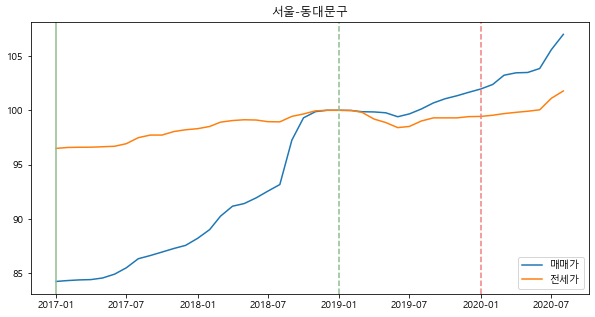

In [28]:
#그래프 그리기

si = '서울'
gu = '동대문구'
index_date = datetime(2020,1,1)

prev_date = index_date - relativedelta(months=12)
prev_date2 = index_date - relativedelta(months=36)
graph_start = index_date - relativedelta(years=3)
graph_end = index_date + relativedelta(years=3)

plt.figure(figsize=(10,5))
plt.title(si + '-' + gu)
plt.plot(price_index[si][gu][graph_start:graph_end], label='매매가')
plt.plot(jeonse_index[si][gu][graph_start:graph_end], label='전세가')

plt.axvline(x=index_date, color='lightcoral', linestyle='--')
plt.axvline(x=prev_date, color='darkseagreen', linestyle='--')
plt.axvline(x=prev_date2, color='darkseagreen', linestyle='-')

plt.legend()
plt.show()

In [29]:
#수요 전략의 결과 데이터프레임에서 지역 이름 가져오기

for name in demand_ex.index:
    print(name)

('서울', '강북')
('서울', '강북구')
('서울', '광진구')
('서울', '노원구')
('서울', '도봉구')
('서울', '동대문구')
('서울', '마포구')
('서울', '서대문구')
('서울', '성동구')
('서울', '성북구')
('서울', '용산구')
('서울', '은평구')
('서울', '종로구')
('서울', '중구')
('서울', '중랑구')
('서울', '강남')
('서울', '강남구')
('서울', '강동구')
('서울', '강서구')
('서울', '관악구')
('서울', '구로구')
('서울', '금천구')
('서울', '동작구')
('서울', '서초구')
('서울', '송파구')
('서울', '양천구')
('서울', '영등포구')
('부산', '중구')
('부산', '서구')
('부산', '동구')
('부산', '영도구')
('부산', '부산진구')
('부산', '동래구')
('부산', '남구')
('부산', '북구')
('부산', '해운대구')
('부산', '사하구')
('부산', '금정구')
('부산', '연제구')
('부산', '수영구')
('부산', '사상구')
('부산', '기장군')
('부산', '강서구')
('대구', '중구')
('대구', '동구')
('대구', '서구')
('대구', '남구')
('대구', '북구')
('대구', '수성구')
('대구', '달서구')
('대구', '달성군')
('인천', '중구')
('인천', '동구')
('인천', '미추홀구')
('인천', '연수구')
('인천', '남동구')
('인천', '부평구')
('인천', '계양구')
('인천', '서구')
('광주', '동구')
('광주', '서구')
('광주', '남구')
('광주', '북구')
('광주', '광산구')
('대전', '동구')
('대전', '중구')
('대전', '서구')
('대전', '유성구')
('대전', '대덕구')
('울산', '중구')
('울산', '남구')
('울산', '동구')
('울산', '북구')

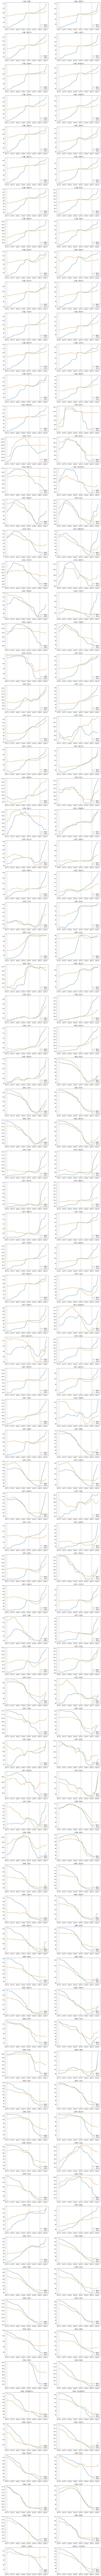

In [30]:
#demand 함수를 이용해 선택된 전 지역 그래프 그리기
index_date = datetime(2020,1,1)
time_range = 12

prev_date = index_date - relativedelta(months=time_range)
prev_date2 = index_date - relativedelta(months=time_range*3)
graph_start = index_date - relativedelta(months=time_range*3)
graph_end = index_date + relativedelta(months=time_range*3)

num_row = int((len(demand_ex.index)-1)/2)+1

plt.figure(figsize=(15, num_row*5))

for i, spot in enumerate(demand_ex.index):
    plt.subplot(num_row, 2, i+1)
    plt.title(spot)
    si = spot[0]
    gu = spot[1]
    plt.plot(price_index[si][gu][graph_start:graph_end], label='매매가')
    plt.plot(jeonse_index[si][gu][graph_start:graph_end], label='전세가')

    plt.axvline(x=index_date, color='lightcoral', linestyle='--')
    plt.axvline(x=prev_date, color='darkseagreen', linestyle='--')
    plt.axvline(x=prev_date2, color='darkseagreen', linestyle='-')
    plt.legend(loc = "lower right")
plt.show()
    